Train full: (75158, 141) | Test: (23459, 141)
Train sub: (62786, 141) | Valid: (12372, 141)

XGBoost (native, early-stopped on validation) — Test results:
MAE: 55.59
RMSE: 88.25
R²: 0.832

Operator Forecast (PROGNOSE_REIZEN) — Test results:
MAE: 61.69
RMSE: 99.62
R²: 0.786


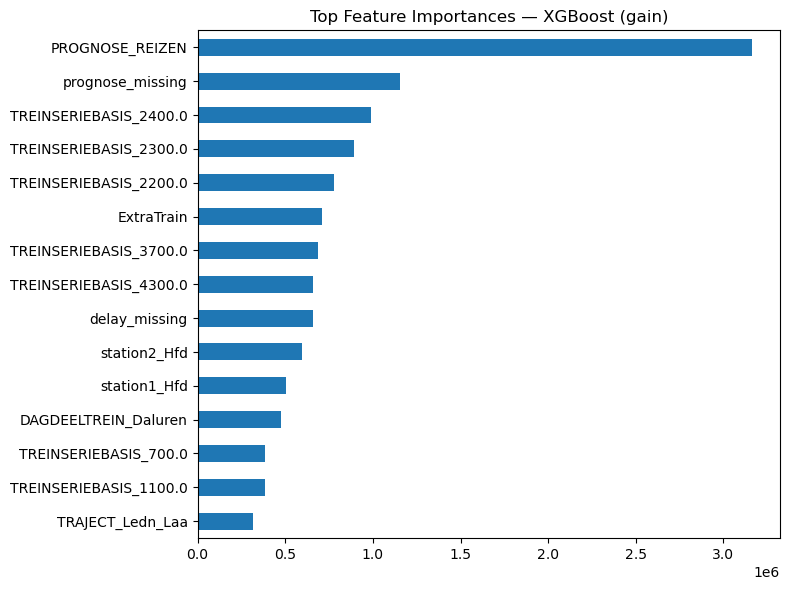

In [3]:
# --- 1) Setup ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

# --- 2) Load data (safer read: low_memory=False; explicit na_values) ---
df = pd.read_csv(
    "/Users/amelijaancupane/Desktop/TU_DELFT/Year 2/Advanced Data Analysis/NS_Project/Group2_NS-1/data/complete_dataset.csv",
    sep=";",
    low_memory=False,
    na_values=["", "NA", "NaN", "NULL"]
)

# --- 3) Cleaning / feature prep ---

# (a) delay: HH:MM:SS -> minutes
if "delay" in df.columns:
    df["delay"] = pd.to_timedelta(df["delay"], errors="coerce").dt.total_seconds() / 60
    df["delay_missing"] = df["delay"].isna().astype("int8")
    df["delay"] = df["delay"].fillna(0)

# (b) drop rows missing the target
df = df.dropna(subset=["REALISATIE"]).copy()

# (c) ensure TREINSERIEBASIS is string (not generic object / mixed)
if "TREINSERIEBASIS" in df.columns:
    df["TREINSERIEBASIS"] = df["TREINSERIEBASIS"].astype("string").fillna("Unknown")

# (d) fill other categoricals we use
for col in ["DAGDEELTREIN"]:
    if col in df.columns:
        df[col] = df[col].astype("string").fillna("Unknown")

# (e) operator forecast missing (extra trains)
if "PROGNOSE_REIZEN" in df.columns:
    df["prognose_missing"] = df["PROGNOSE_REIZEN"].isna().astype("int8")
    df["PROGNOSE_REIZEN"] = df["PROGNOSE_REIZEN"].fillna(0)

# (f) Weather columns -> one-hot/binary flags (no leakage; simple mapping)
#   Rain: values -> {NaN, "Rain", "Heavy Rain"}
#   Gusts: {NaN, "Heavy Wind"}
#   Storms: {NaN, "Thunderstorm"}
if "Rain" in df.columns:
    df["Rain_flag"] = df["Rain"].notna().astype("int8")
    df["Heavy_Rain_flag"] = (df["Rain"] == "Heavy Rain").astype("int8")
if "Gusts" in df.columns:
    df["Gusts_flag"] = df["Gusts"].notna().astype("int8")  # 1 if Heavy Wind present
if "Storms" in df.columns:
    df["Storms_flag"] = df["Storms"].notna().astype("int8")  # 1 if Thunderstorm present

# (g) (optional) simple keyword flags from Disruption description
if "Disruption description" in df.columns:
    s = df["Disruption description"].fillna("").str.lower()
    df["disrupt_any"]   = (s.str.len() > 0).astype("int8")
    df["disrupt_signal"] = s.str.contains("signal", na=False).astype("int8")
    df["disrupt_track"]  = s.str.contains("track|rail", na=False).astype("int8")
    df["disrupt_power"]  = s.str.contains("overhead|power|line", na=False).astype("int8")

# (h) ensure boolean columns are numeric ints for XGBoost
for col in ["Cancelled", "ExtraTrain"]:
    if col in df.columns:
        if df[col].dtype == "bool":
            df[col] = df[col].astype("int8")

# (i) reset index after drops (tidy)
df = df.reset_index(drop=True)

# --- target and features ---
y = df["REALISATIE"]

base_features = [
    "WEEK_DAG_NR", "TRAJECT", "DAGDEELTREIN", "TREINSERIEBASIS",
    "PROGNOSE_REIZEN", "station1", "station2",
    "Cancelled", "ExtraTrain", "delay", "delay_missing", "prognose_missing"
]

weather_features = [c for c in ["Rain_flag", "Heavy_Rain_flag", "Gusts_flag", "Storms_flag"] if c in df.columns]
disrupt_features = [c for c in ["disrupt_any", "disrupt_signal", "disrupt_track", "disrupt_power"] if c in df.columns]

# keep only features that exist in df
features = [c for c in (base_features + weather_features + disrupt_features) if c in df.columns]
X = df[features].copy()

# one-hot encode categoricals
categorical_cols = [c for c in ["TRAJECT", "DAGDEELTREIN", "TREINSERIEBASIS", "station1", "station2"] if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 4) Chronological split ---
cutoff_day = df["DAGNR"].max() - 7          # last 7 days as test
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

X_train_full = X[train_mask]
y_train_full = y[train_mask]
X_test       = X[test_mask]
y_test       = y[test_mask]

print("Train full:", X_train_full.shape, "| Test:", X_test.shape)

# --- 5) Validation split inside training (chronological) ---
train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))  # ~20% of training days
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()

if len(tr_days) == 0:   # fallback if tiny
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr, y_tr = X[train_sub_mask], y[train_sub_mask]
X_va, y_va = X[valid_mask],     y[valid_mask]

print("Train sub:", X_tr.shape, "| Valid:", X_va.shape)

# --- 6) XGBoost (native API) with early stopping on validation ---
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "eta": 0.03,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42
}

# Build DMatrices (pass feature names so importance lines up)
feature_names = list(X.columns)
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=feature_names)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test, feature_names=feature_names)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=200,
    verbose_eval=False
)

# --- 7) Evaluate on TEST set ---
y_pred = bst.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nXGBoost (native, early-stopped on validation) — Test results:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 3))

# --- Operator baseline ---
if "PROGNOSE_REIZEN" in df.columns:
    op_pred  = df.loc[test_mask, "PROGNOSE_REIZEN"]
    op_mae   = mean_absolute_error(y_test, op_pred)
    op_rmse  = np.sqrt(mean_squared_error(y_test, op_pred))
    op_r2    = r2_score(y_test, op_pred)

    print("\nOperator Forecast (PROGNOSE_REIZEN) — Test results:")
    print("MAE:", round(op_mae, 2))
    print("RMSE:", round(op_rmse, 2))
    print("R²:", round(op_r2, 3))

# --- 8) Feature importance (gain) ---
score_dict = bst.get_score(importance_type="gain")
fi = pd.Series({f: score_dict.get(f, 0.0) for f in feature_names}).sort_values(ascending=True).tail(15)
fi.plot(kind="barh", figsize=(8,6))
plt.title("Top Feature Importances — XGBoost (gain)")
plt.tight_layout()
plt.show()


Not updated:

Train full: (75153, 133) | Test: (23459, 133)
Train sub: (62782, 133) | Valid: (12371, 133)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 62782, number of used features: 118
[LightGBM] [Info] Start training from score 293.057858

LightGBM (early-stopped on validation) — Test results:
MAE: 58.18
RMSE: 89.88
R²: 0.826

Operator Forecast (PROGNOSE_REIZEN) — Test results:
MAE: 61.69
RMSE: 99.62
R²: 0.786


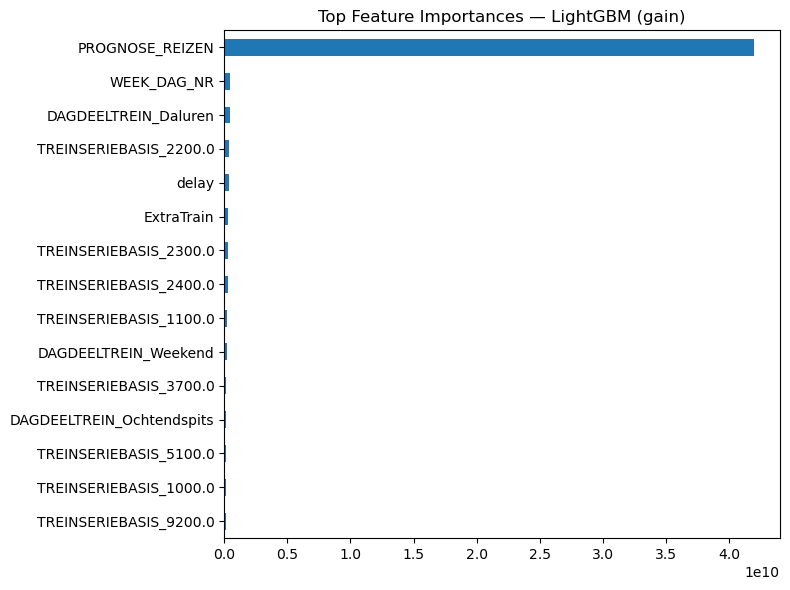

In [12]:
# --- 1) Setup ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import lightgbm as lgb

# --- 2) Load data ---
df = pd.read_csv(
    "/Users/amelijaancupane/Desktop/TU_DELFT/Year 2/Advanced Data Analysis/NS_Project/Group2_NS-1/data/data_NS_filtered.csv",
    sep=";"
)

# --- 3) Cleaning / feature prep ---
# delay: HH:MM:SS -> minutes
df["delay"] = pd.to_timedelta(df["delay"], errors="coerce").dt.total_seconds() / 60

# drop rows missing the target
df = df.dropna(subset=["REALISATIE"]).copy()

# fill categoricals we use
for col in ["DAGDEELTREIN", "TREINSERIEBASIS"]:
    df[col] = df[col].fillna("Unknown")

# delay missing flag + fill 0
df["delay_missing"] = df["delay"].isna().astype(int)
df["delay"] = df["delay"].fillna(0)

# operator forecast missing (extra trains)
df["prognose_missing"] = df["PROGNOSE_REIZEN"].isna().astype(int)
df["PROGNOSE_REIZEN"] = df["PROGNOSE_REIZEN"].fillna(0)

# --- target and features ---
y = df["REALISATIE"]
features = [
    "WEEK_DAG_NR", "TRAJECT", "DAGDEELTREIN", "TREINSERIEBASIS",
    "PROGNOSE_REIZEN", "station1", "station2",
    "Cancelled", "ExtraTrain", "delay", "delay_missing", "prognose_missing"
]
X = df[features].copy()

# one-hot encode categoricals (keeps things consistent with your other notebooks)
categorical_cols = ["TRAJECT", "DAGDEELTREIN", "TREINSERIEBASIS", "station1", "station2"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 4) Chronological split: last 7 days = TEST ---
cutoff_day = df["DAGNR"].max() - 7
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

X_train_full = X[train_mask]
y_train_full = y[train_mask]
X_test       = X[test_mask]
y_test       = y[test_mask]

print("Train full:", X_train_full.shape, "| Test:", X_test.shape)

# --- 5) Validation split inside training (chronological) ---
train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))  # ~20% of training days
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()

if len(tr_days) == 0:
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr, y_tr = X[train_sub_mask], y[train_sub_mask]
X_va, y_va = X[valid_mask],     y[valid_mask]

print("Train sub:", X_tr.shape, "| Valid:", X_va.shape)

# --- 6) LightGBM with early stopping on validation ---
lgbm = lgb.LGBMRegressor(
    n_estimators=5000,       # high cap; early stopping will pick best iteration
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,            # let LGBM choose; can tune (e.g., 6–10)
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="regression",
    random_state=42,
    n_jobs=-1
)

# use callback form for broad version compatibility
callbacks = [
    lgb.early_stopping(stopping_rounds=200, verbose=False)  # no test-set leakage
]

lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="mae",
    callbacks=callbacks
)

# --- 7) Evaluate on TEST set ---
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nLightGBM (early-stopped on validation) — Test results:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 3))

# --- Operator baseline ---
op_pred  = df.loc[test_mask, "PROGNOSE_REIZEN"]
op_mae   = mean_absolute_error(y_test, op_pred)
op_rmse  = np.sqrt(mean_squared_error(y_test, op_pred))
op_r2    = r2_score(y_test, op_pred)

print("\nOperator Forecast (PROGNOSE_REIZEN) — Test results:")
print("MAE:", round(op_mae, 2))
print("RMSE:", round(op_rmse, 2))
print("R²:", round(op_r2, 3))

# --- 8) Feature importance ---
importances = lgbm.booster_.feature_importance(importance_type="gain")
fi = pd.Series(importances, index=X_train_full.columns).sort_values(ascending=True).tail(15)
fi.plot(kind="barh", figsize=(8,6))
plt.title("Top Feature Importances — LightGBM (gain)")
plt.tight_layout()
plt.show()
